# Data I/O, featurization and coordinate transforms in PyEMMA
## Loading MD example data from our FTP server
Ingredients:
- Topology file: PDB
- Trajectory data: List of .XTC files

In [1]:
from mdshare import fetch

In [2]:
topfile = fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
traj_list = [fetch('alanine-dipeptide-%d-250ns-nowater.xtc' % i, working_directory='data') for i in range(3)]

The `fetch` function fetches the data from our servers. **Do not use `mdshare` for your own data!**

## Import PyEMMA & friends

In [3]:
import pyemma
import deeptime as dt
import numpy as np
import matplotlib.pyplot as plt
plt.matplotlib.rcParams.update({'font.size': 16})

## The featurizer
All information for data processing (raw MD -> observable) is stored in a `Featurizer` object.

In [4]:
featurizer = pyemma.coordinates.featurizer(topfile)

Features are simply added like this:
```python
featurizer.add_my_feature()
```
For example, we will add all heavy atom distances by first selecting heavy atoms

In [5]:
heavy_atom_indices = featurizer.select_Heavy()
heavy_atom_indices

array([ 1,  4,  5,  6,  8, 10, 14, 15, 16, 18])

... and by adding distances between them:

In [6]:
featurizer.add_distances(heavy_atom_indices, periodic=False)

22-02-21 10:31:45 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


Check the output of describe() to see the actual order of the features


We can add several different features; to find out which ones have been added, simply use `featurizer.describe()`.

In [7]:
featurizer.describe()

['DIST: ACE 1 CH3 1 - ACE 1 C 4',
 'DIST: ACE 1 CH3 1 - ACE 1 O 5',
 'DIST: ACE 1 CH3 1 - ALA 2 N 6',
 'DIST: ACE 1 CH3 1 - ALA 2 CA 8',
 'DIST: ACE 1 CH3 1 - ALA 2 CB 10',
 'DIST: ACE 1 CH3 1 - ALA 2 C 14',
 'DIST: ACE 1 CH3 1 - ALA 2 O 15',
 'DIST: ACE 1 CH3 1 - NME 3 N 16',
 'DIST: ACE 1 CH3 1 - NME 3 C 18',
 'DIST: ACE 1 C 4 - ACE 1 O 5',
 'DIST: ACE 1 C 4 - ALA 2 N 6',
 'DIST: ACE 1 C 4 - ALA 2 CA 8',
 'DIST: ACE 1 C 4 - ALA 2 CB 10',
 'DIST: ACE 1 C 4 - ALA 2 C 14',
 'DIST: ACE 1 C 4 - ALA 2 O 15',
 'DIST: ACE 1 C 4 - NME 3 N 16',
 'DIST: ACE 1 C 4 - NME 3 C 18',
 'DIST: ACE 1 O 5 - ALA 2 N 6',
 'DIST: ACE 1 O 5 - ALA 2 CA 8',
 'DIST: ACE 1 O 5 - ALA 2 CB 10',
 'DIST: ACE 1 O 5 - ALA 2 C 14',
 'DIST: ACE 1 O 5 - ALA 2 O 15',
 'DIST: ACE 1 O 5 - NME 3 N 16',
 'DIST: ACE 1 O 5 - NME 3 C 18',
 'DIST: ALA 2 N 6 - ALA 2 CA 8',
 'DIST: ALA 2 N 6 - ALA 2 CB 10',
 'DIST: ALA 2 N 6 - ALA 2 C 14',
 'DIST: ALA 2 N 6 - ALA 2 O 15',
 'DIST: ALA 2 N 6 - NME 3 N 16',
 'DIST: ALA 2 N 6 - NME 3 C

There are some more handy methods that come with the featurizer:

In [8]:
featurizer.dimension()

45

In [9]:
featurizer.select("element C")

array([ 1,  4,  8, 10, 14, 18])

In [10]:
featurizer.pairs([1, 8, 18])

array([[ 1,  8],
       [ 1, 18],
       [ 8, 18]])

## loading featurized data
When dealing with datasets that fit into memory, we preferably load the data directly with
#### `load`

In [11]:
Y = pyemma.coordinates.load(traj_list, featurizer)

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

Alternatively, for high memory demands, the data can be streamed with
#### `source`

In [12]:
source = pyemma.coordinates.source(traj_list, featurizer)

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

The source object has some useful properties. e.g.

In [13]:
source.trajectory_lengths()

array([250000, 250000, 250000])

We go on with the data in our memory, `Y`. Let's do a component-wise histogram plot of the loaded data:

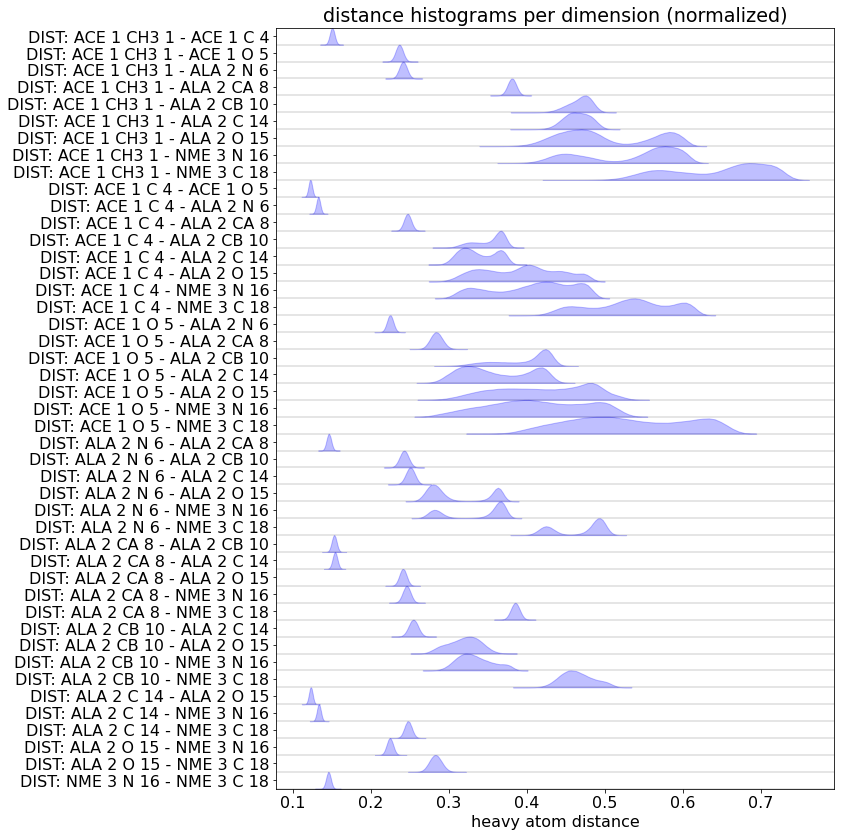

In [14]:
fig, ax = plt.subplots(figsize=(10, 14))
pyemma.plots.plot_feature_histograms(np.concatenate(Y), 
                                     feature_labels=featurizer, 
                                     ax=ax)
ax.set_xlabel('heavy atom distance')
ax.set_title('distance histograms per dimension (normalized)');

## Dimension reduction
The very high dimensional space can be transformed into a lower dimensional representation of the dynamics e.g. with TICA:

First, we create an estimator of type TICA which allows us to fit data to it and then retrieve one or multiple TICA models.

In [15]:
tica_estimator = dt.decomposition.TICA(lagtime=10, var_cutoff=0.95)

With the estimator, we fit data (``Y``) and then ``fetch_model``.

In [16]:
tica = tica_estimator.fit(Y).fetch_model()

We obtain a TICA model python object. We get the transformed data (`tics`) from it:

In [17]:
tics = tica.transform(Y)

The TICA object contains useful properties such as the number of dimension that explain `var_cutoff` of the kinetic variance. The output data has the same shape.

In [18]:
tica.output_dimension

2

Let's visualize these two dimensions in a 2D histogram:

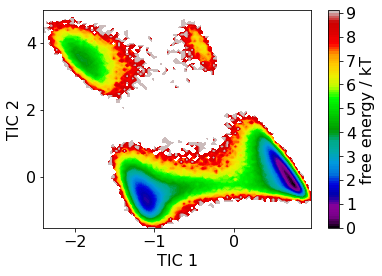

In [19]:
pyemma.plots.plot_free_energy(np.concatenate(tics)[:, 0], np.concatenate(tics)[:, 1])
plt.xlabel('TIC 1') 
plt.ylabel('TIC 2');

## VAMP-scoring
We can use the VAMP-2 score e.g. to assess how many dimensions we should ideally take. We check for

In [20]:
dims = [1, 2, 3, 5]

To avoid overfitting, we perform cross validation:

Text(0.5, 0, '# dimensions')

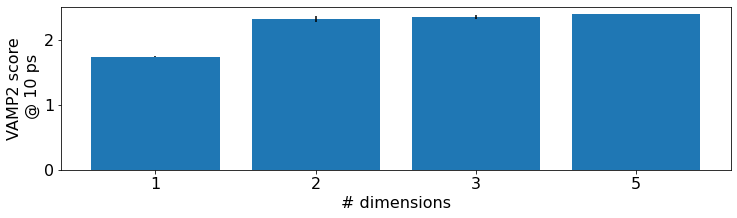

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharey=True)

scores = []
errors = []

tica_estimator.var_cutoff = None  # this takes precedence over dim if it is set
for dim in dims:
    tica_estimator.dim = dim
    torsions_scores = dt.decomposition.vamp_score_cv(tica_estimator, trajs=Y, 
                                                     blocksplit=False, n=3)
    scores.append(torsions_scores.mean())
    errors.append(torsions_scores.std())

ax.bar([str(d) for d in dims], scores, yerr=errors)

ax.set_ylabel('VAMP2 score\n @ {} ps'.format(tica_estimator.lagtime))
ax.set_xlabel('# dimensions')

We note that the VAMP-2 score is converged at 2 dimensions.

## Discretization / clustering
There are different ways of clustering the data, we use $k$-means here.

Same as with TICA, we first create an estimator and then obtain a clustering model from it.

In [22]:
kmeans_estimator = dt.clustering.KMeans(n_clusters=75, max_iter=30)
clustering = kmeans_estimator.fit(np.concatenate(tics)).fetch_model()

/home/mho/Development/deeptime/deeptime/clustering/_kmeans.py:406: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 30 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


As before, the clustering routine returns an object with several useful properties and methods. For example, let us visualize the cluster centers stored in `clustering.cluster_centers`:

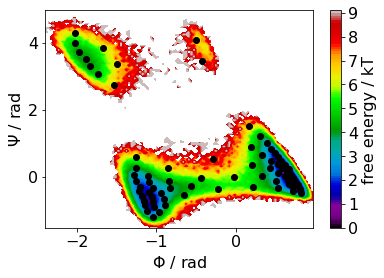

In [23]:
fig, ax = plt.subplots()
ax.plot(*clustering.cluster_centers.T, 'ko')
pyemma.plots.plot_free_energy(*np.concatenate(tics).T, ax=ax)
ax.set_xlabel('$\Phi$ / rad') 
ax.set_ylabel('$\Psi$ / rad');

Most importantly, the clustering object contains the discrete trajectories that we need for later MSM estimation. Each frame in each trajectory gets assigned to one of the cluster centers here.

In [24]:
dtrajs = []
for projected_trajectory in tics:
    dtrajs.append(clustering.transform(projected_trajectory))

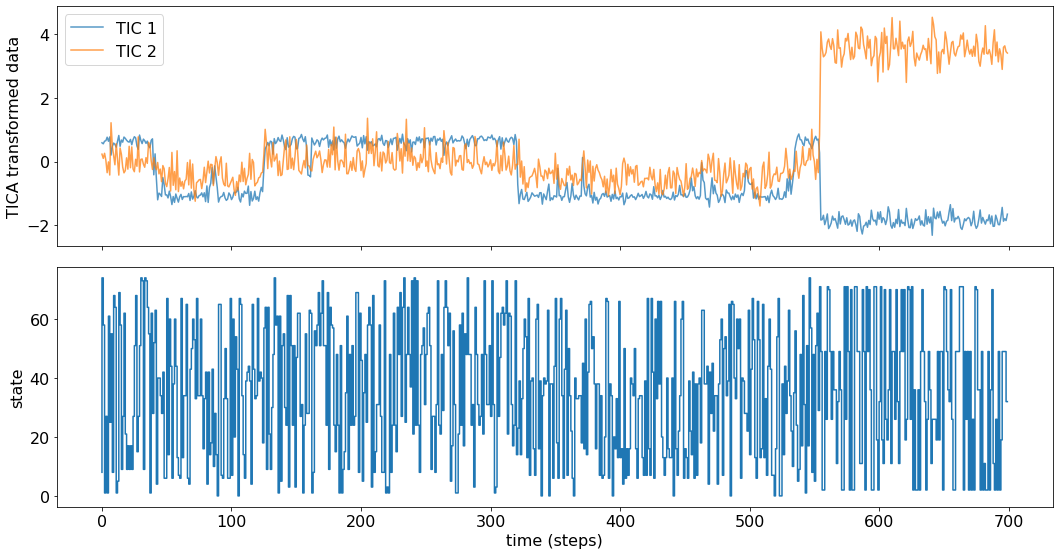

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
b, e = 20400, 21100
ax[0].plot(tics[0][b:e, 0], alpha=.75, label='TIC 1')
ax[0].plot(tics[0][b:e, 1], alpha=.75, label='TIC 2')
ax[0].set_ylabel('TICA transformed data')
ax[0].legend()
ax[1].step(range(dtrajs[0][b:e].shape[0]), dtrajs[0][b:e])
ax[1].set_xlabel('time (steps)')
ax[1].set_ylabel('state')
fig.tight_layout()

In [26]:
print(dtrajs[0][:25])

[ 0 50 13 22 65 14 33 13 39 33 67  7 50  7  6 34 60 20 67 13 16 34 40 67
 66]
